## Imports

In [1]:
%matplotlib inline
from importlib import reload
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from matplotlib import patches

import ics.cobraCharmer.pfi as pfiControl
from ics.cobraCharmer import pfiDesign

from ics.cobraCharmer.utils import butler
from procedures.moduleTest import moduleTest, calculation

In [102]:
%store phiRuns
%store thetaRuns

Stored 'phiRuns' (dict)
Stored 'thetaRuns' (dict)


In [2]:
%store -r phiRuns thetaRuns

In [2]:
def loadSpots(outputPath):
    try:
        spots = np.load(outputPath / 'spots.npz')['spots']
    except:
        spots = None
    try:
        moves = np.load(outputPath / 'moves.npz')['moves']
    except:
        moves = None
        
    if moves is None and spots is None:
        raise RuntimeError(f'no output in {outputPath}')
        
    return spots, moves

def loadPhiCenters(runDir):
    phiCenters = np.load(runDir / 'data' / 'phiCenter.npy')
    return phiCenters

def getFiberInfo(spots, moves, cobra, module=None):
    if module is not None:
        raise ValueError('can only deal with one module')
    fiberDtype = np.dtype(dict(names=['cobra', 'expId', 'x', 'y', 'phiSteps', 'thetaSteps'],
                               formats=['i2', 'U12', 'f4', 'f4', 'i4', 'i4']))
    w = np.where(moves['cobra'] == cobra)[0]
    fibers = np.zeros(len(w), dtype=fiberDtype)
    
    ourMoves = moves[w]
    
    # Yuck. Cannot figure out how to do this without loops
    spots_w = np.zeros(len(w), dtype='i4')
    for move_i, move in enumerate(ourMoves):
        spots_w[move_i] = np.where((spots['expId'] == move['expId']) & 
                                   (spots['spotId'] == move['spotId']))[0]
    ourSpots = spots[spots_w]
        
    fibers['cobra'][:] = cobra
    fibers['expId'][:] = ourSpots['expId']
    fibers['x'][:] = ourSpots['x']
    fibers['y'][:] = ourSpots['y']
    fibers['phiSteps'][:] = ourMoves['phiSteps']
    fibers['thetaSteps'][:] = ourMoves['thetaSteps']
    
    return fibers

def splitPhiRvFw(moves):
    fw_w = np.concatenate([[0], np.where(moves['phiSteps'] > 0)[0]])
    farHome_w = fw_w[-1]
    rv_w = np.arange(farHome_w, len(moves))
    
    return fw_w, rv_w


In [3]:

def plotMotormap(map, figname='motormap', ids=None):
    f, pl = plt.subplots(num=figname, figsize=(10,10), clear=True)
    pl.set_aspect('equal')
    
    for i in range(map.nCobras):
        posId = map.positionerIds[i]
        if ids and not posId in ids:
            continue
        ctr = map.centers[i]
        ctrx, ctry = ctr.real, ctr.imag
        pl.plot(ctrx, ctry, 'b+', alpha=0.6)
        pl.text(ctrx, ctry, posId, fontsize=8, 
                horizontalalignment='center')

    return f, pl

def plotPhiArcs(spots, centers, figname='phiCenters', map=None):
    f, pl = plt.subplots(num=figname, figsize=(10,10), clear=True)
    pl.set_aspect('equal')
    
    # ctrx, ctry = centers.real, centers.imag
    #pl.plot(ctrx, ctry, '+')

    for spot in spots:
        x, y = spot['x'], spot['y']
        pl.plot(x, y, '.', color='red', alpha=0.4, markersize=0.5)
    return f, pl

def plotCobras(model, spots, moves, figname='cobras', phiMeasures=None):
    f, pl = plt.subplots(nrows=10, ncols=6, clear=True,
                         sharey='row', sharex='col',
                         num=figname, figsize=(12*(6/10), 12))
    plist = pl.flatten()
    for p in plist:
        p.set_aspect('equal')
            
    modelCenters = model.centers
    nspots = len(spots)
    for c_i in range(57):
        cobraId = c_i + 1
        cobraSpots = getFiberInfo(spots, moves, cobraId)
        fw_w, rv_w = splitPhiRvFw(cobraSpots)

        modelCenter = modelCenters[c_i]
        modelX, modelY = modelCenter.real, modelCenter.imag
        x = cobraSpots['x']
        y = cobraSpots['y']

        ox = x - modelX
        oy = y - modelY

        p = plist[c_i]
        p.plot(0, 0, '+')
        # p.text(0, 0, f'({modelX:0.1f}, {modelY:0.1f})', horizontalalignment='center')
        circle = patches.Circle((0,0), model.L2[c_i], fill=False,
                                alpha=0.2)
        p.add_patch(circle)
        p.plot(ox[fw_w], oy[fw_w], '.', color='red', alpha=0.4) # , markersize=2)
        p.plot(ox[rv_w], oy[rv_w], '.', color='blue', alpha=0.4) # , markersize=2)

        
        if phiMeasures is not None:
            phiCenter, phiRadius, phiFW, phiRV = (phiMeasures[0][c_i],
                                                  phiMeasures[1][c_i],
                                                  phiMeasures[2][c_i],
                                                  phiMeasures[3][c_i])
            pcx, pcy = phiCenter.real, phiCenter.imag
            
            #p.plot(pcx-modelX, pcy-modelY, 'or')
            p.plot(np.cos(phiFW)*phiRadius, np.sin(phiFW)*phiRadius, '.', alpha=0.3)

    # f.tight_layout(h_pad=0, w_pad=0, pad=0)
    return f, pl

In [42]:
from matplotlib.ticker import MaxNLocator

def plotPhiConvergence(dataPaths):
    if isinstance(dataPaths, (str, pathlib.Path)):
        dataPaths = [dataPaths]
    nRuns = len(dataPaths)
    if nRuns == 1:
        nrows = 2
        ncols = 1
    else:
        nrows = nRuns
        ncols = 2
        
    f, pl = plt.subplots(nrows=nrows, ncols=ncols, sharex=True,
                         num='convergenceTest',
                         figsize=(12, 2*nrows))

    for run_i, dataPath in enumerate(dataPaths):
        data = np.load(dataPath)

        dataPath = dataPath.resolve()
        runPath = dataPath.parent.parent
        runName = runPath.name
        p1, p2 = pl[run_i]
    
        cobras =  np.unique(data['cobra'])
        lastIteration = np.max(data['iteration'])

        p1.hlines(0, 0, lastIteration + 1, 'k', alpha=0.2)
        for c_i in cobras:
            if c_i == 0:
                continue
            c_w = np.where(data['cobra'] == c_i)
            p1.plot(np.rad2deg(data['left'][c_w]), '-+', alpha=0.5)
            p1.set_title(runName)
            p1.set_ylabel('degrees')
            p1.xaxis.set_major_locator(MaxNLocator(integer=True))

        duds = np.where((data['iteration'] == lastIteration) & (data['done'] == False))

        if lastIteration >= 7 and len(duds[0]) > 0:
            skip = 1
            dudCobras = np.unique(data['cobra'][duds])
            x = np.arange(skip, lastIteration+1)
            p2.hlines(0, x[0], x[-1], 'k', alpha=0.2)        

            for c_i in dudCobras:
                c_w = np.where(data['cobra'] == c_i)
                p2.plot(x, np.rad2deg(data['left'][c_w])[skip:], '-+', alpha=0.5, label=f'{c_i}')
                p2.set_title(f'{runName} failures')
                p2.set_ylabel('degrees')
                p2.xaxis.set_major_locator(MaxNLocator(integer=True))
                p2.legend()
        else:
            skip = 2 if lastIteration > 4 else 1
            x = np.arange(skip, lastIteration+1)
            p2.hlines(0, x[0], x[-1], 'k', alpha=0.2)
            for c_i in cobras:
                if c_i == 0:
                    continue
                c_w = np.where(data['cobra'] == c_i)
                p2.plot(x, np.rad2deg(data['left'][c_w][skip:]), '-+', alpha=0.5)
                p2.set_ylim(-5,5)
                p2.set_title(f'{runName} end moves')
                p2.set_ylabel('degrees')
                p2.xaxis.set_major_locator(MaxNLocator(integer=True))

        f.tight_layout()
    return data

def plotConvergenceSummary(dataPaths):
    if isinstance(dataPaths, (str, pathlib.Path)):
        dataPaths = [dataPaths]
    nRuns = len(dataPaths)

    f, pl = plt.subplots(nrows=2, 
                         num='convergenceSummary',
                         figsize=(12, 8))
    p1, p2 = pl
    
    cobras = set()
    lastIteration = 0
    for run_i, dataPath in enumerate(dataPaths):
        data = np.load(dataPath)

        cobras1 =  np.unique(data['cobra'])
        cobras.update(cobras1.tolist())
        lastIteration1 = np.max(data['iteration'])
        lastIteration = max(lastIteration, lastIteration1)
        
    cobras = sorted(cobras)
    doneAt = np.zeros((max(cobras)+1, nRuns), dtype='i4')
    
    for run_i, dataPath in enumerate(dataPaths):
        data = np.load(dataPath)
    
        for i in range(lastIteration, 0, -1):
            i_w = np.where((data['iteration'] == i) & (data['done'] == True))
            doneCobras = data['cobra'][i_w]
            for c_i in doneCobras:
                doneAt[doneCobras,run_i] = i
                
    _ = p1.hist(doneAt.T, histtype='barstacked', bins=np.arange(np.max(doneAt)+1), 
                density=True, align='left')
    p1.set_ylabel(f'percent of {len(cobras)} cobras in {nRuns} runs')
    p1.set_xlabel('steps to convergence')

    return doneAt
    

Automatic pdb calling has been turned ON
Automatic pdb calling has been turned OFF


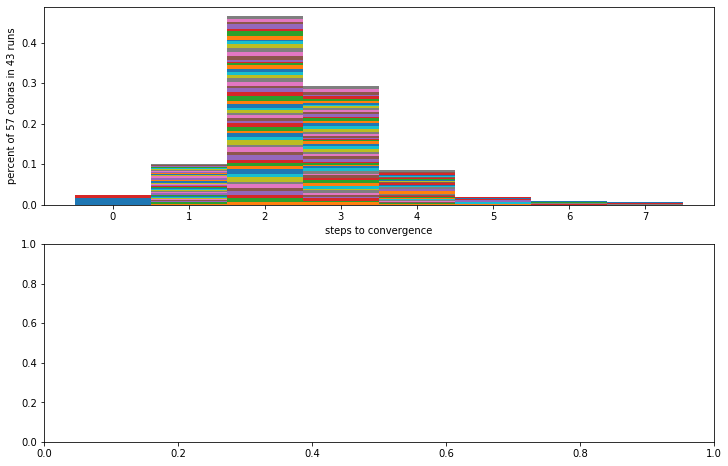

In [43]:
%pdb on 
doneAt = plotConvergenceSummary(runPaths[4:])
%pdb off

In [ ]:
plt.hist()

In [11]:
plt.close('all')

Automatic pdb calling has been turned ON
Automatic pdb calling has been turned OFF


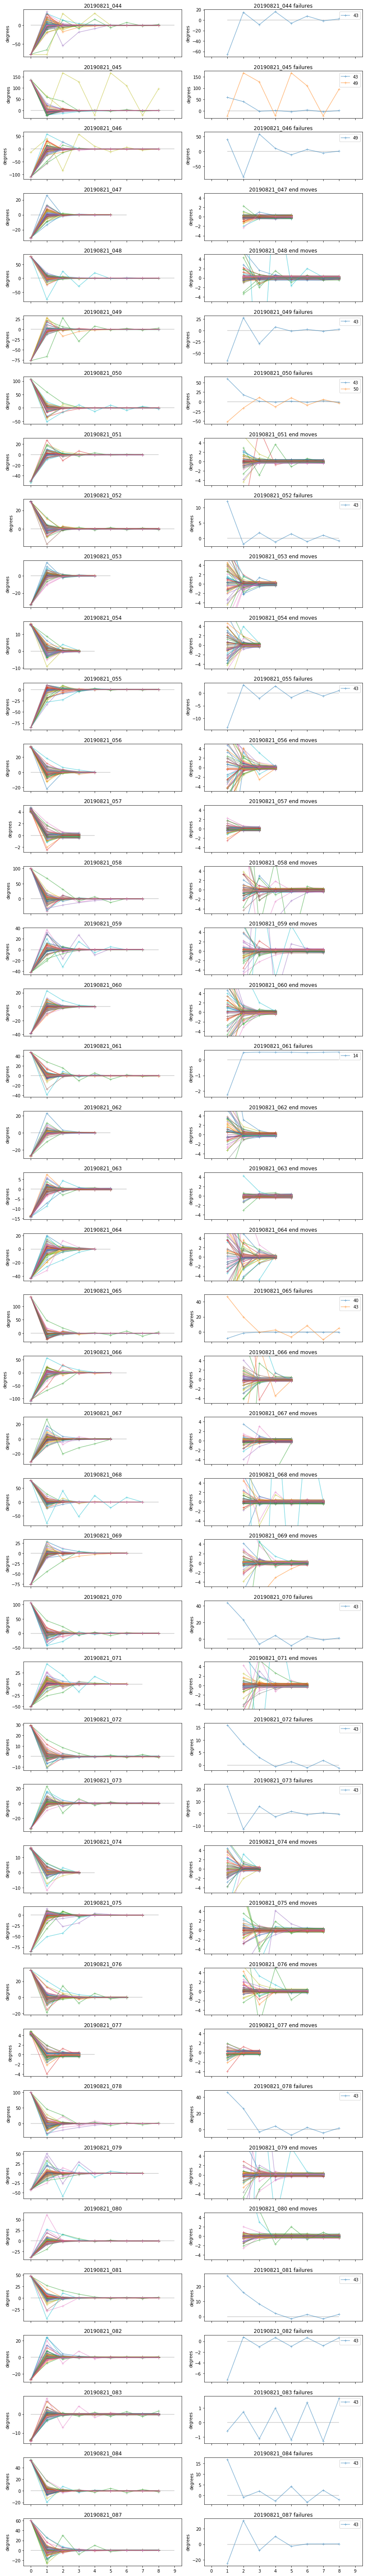

In [39]:
dataRoot = pathlib.Path('/data/MCS')
runPaths = sorted(dataRoot.glob('201908*/output/phiConvergence.npy'))
len(runPaths)
%pdb on
plotPhiConvergence(runPaths[5:])
%pdb off
#runDir = pathlib.Path(r'/data/MCS/20190821_043')
#conv = plotPhiConvergence(runDir)

In [30]:
import pandas as pd

In [33]:
df =  pd.DataFrame(conv)
df

,iteration,cobra,target,position,left,done
0,7,1,60.0,1.048613,-0.001415,1
1,1,2,60.0,2.527215,-1.480017,0
2,2,2,60.0,0.725240,0.321957,0
3,3,2,60.0,1.385532,-0.338334,0
4,4,2,60.0,0.957864,0.089333,0
5,5,2,60.0,1.083359,-0.036161,0
6,6,2,60.0,1.042858,0.004339,1
7,7,2,60.0,1.043571,0.003626,1
8,4,3,60.0,1.057459,-0.010261,0
9,3,4,60.0,1.048579,-0.001381,1


In [31]:
conv = plotPhiConvergence(runDir)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

1: 1
2: 7
3: 4
4: 4
5: 4
6: 3
7: 2
8: 1
9: 4
10: 4
11: 3
12: 7
13: 2
14: 7
15: 1
16: 3
17: 4
18: 7
19: 2
20: 7
21: 3
22: 1
23: 4
24: 7
25: 2
26: 3
27: 4
28: 4
29: 1
30: 7
31: 2
32: 7
33: 4
34: 4
35: 4
36: 1
37: 2
38: 7
39: 4
40: 4
41: 3
42: 7
43: 1
44: 7
45: 4
46: 3
47: 4
48: 7
49: 2
50: 1
51: 3
52: 4
53: 4
54: 7
55: 2
56: 3
57: 1


In [4]:
phiRuns.keys()

NameError: name 'phiRuns' is not defined

## Ginga

In [12]:
from ginga.web.pgw import ipg
use_opencv = True
server = ipg.make_server(host='localhost', port=9914, use_opencv=use_opencv)
server.start(no_ioloop=True)

In [13]:
v2 = server.get_viewer('v2', width=1200, height=1200)
v2.open()

2019-08-08T14:04:02.685 30 tornado.access web.py:2246 404 GET /js/ginga_pg.css (::1) 1.00ms


In [14]:
# Example of embedding a viewer
v2.embed(width=1200, height=1200)

2019-08-08T14:04:05.134 30 tornado.access web.py:2246 404 GET /js/ginga_pg.css (127.0.0.1) 2.00ms
2019-08-08T14:04:05.260 30 tornado.access web.py:2246 404 GET /js/ginga_pg.css (127.0.0.1) 1.00ms


In [16]:
filename = pathlib.Path('/data/MCS/20190808_000/data/thetaForwardStack0.fits')
v2.load_fits(str(filename))

## Bootstrap

In [52]:
from procedures.cit import bootstrapModule
reload(bootstrapModule)

<module 'procedures.cit.bootstrapModule' from 'c:\\users\\cobra\\documents\\pfssoft\\devel\\ics_cobraCharmer\\procedures\\procedures\\cit\\bootstrapModule.py'>

In [ ]:
%pdb on
bootstrapMap = bootstrapModule.bootstrapModule('SC42', numberCobrasFromRight=True)
print(bootstrapMap)
%pdb off

Automatic pdb calling has been turned ON


NameError: name 'bootstrapModule' is not defined

> <ipython-input-31-fbd8b43ddf84>(2)<module>()
      1 get_ipython().run_line_magic('pdb', 'on')
----> 2 bootstrapMap = bootstrapModule.bootstrapModule('SC42', numberCobrasFromRight=True)
      3 print(bootstrapMap)
      4 get_ipython().run_line_magic('pdb', 'off')



## ModuleTest

In [59]:
reload(moduleTest)
mt = moduleTest.ModuleTest('fpga', butler.mapPathForModule('SC42', version='thetaOntime'))
mt._connect()
pfi = mt.pfi
mtMap =  mt.cal.calibModel

2019-08-09T07:58:49.056 30 butler     butler.py:54 newRun: \data\MCS\20190809_010
c:\users\cobra\documents\pfssoft\devel\ics_cobraCharmer\python\ics\cobraCharmer\pfiDesign.py:53: UserWarning: please use PFIDesign.loadModule() or PFIDesign.loadPFI()
  warnings.warn('please use PFIDesign.loadModule() or PFIDesign.loadPFI()')
2019-08-09T07:58:49.219 20 camera     citCam.py:13 cit...


In [5]:
ret2 = mt.exposeAndExtractPositions()

[Initialize]: DRV_SUCCESS


2019-08-08T17:48:38.589 20 camera     camera.py:273 PFCC00003907: 57 spots, get: 0.215 save: 0.044 total: 0.259


In [55]:
mt.pfi.moveAllSteps(mt.allCobras[:2], -4000, -1500)

In [50]:
mt.pfi.calibModel.tht0

array([4.02519688, 2.96324499, 1.00256045, 3.13833281, 2.46433993,
       0.68147115, 2.14599825, 6.22970375, 4.52200901, 4.78860673,
       6.11383756, 2.76212651, 3.36254911, 3.07626938, 5.07474378,
       5.36878466, 3.5095887 , 1.53465077, 2.46125766, 3.98577305,
       2.96362886, 1.29286201, 5.75955567, 5.41676269, 1.83768927,
       2.49197297, 2.65644353, 0.65244212, 5.6607717 , 4.87642307,
       0.6451047 , 3.95453209, 5.32479541, 4.02212277, 1.09676611,
       4.54886257, 0.0176503 , 0.97437804, 2.88625038, 2.26272123,
       2.19779707, 6.06940338, 5.39713983, 0.76177228, 0.89565935,
       6.03004717, 2.88608884, 0.35539787, 2.33422289, 2.4831223 ,
       2.57524604, 6.25460101, 0.97165827, 4.81574899, 1.738938  ,
       0.23013407, 4.84883048])

In [52]:
mt.pfi.thetaToLocal(mt.allCobras[:1], [2])

array([4.25798843])

In [ ]:
%pdb on
thetas = np.zeros(len(mt.allCobras))
thetas[::2] = 90
thetas[1::2] = 270

mt.moveToThetaPhi(np.arange(2), thetas, 60, threshold=1)
%pdb off

Automatic pdb calling has been turned ON


2019-08-09T08:00:10.988 20 camera     camera.py:273 PFCC00003933: 57 spots, get: 0.226 save: 0.123 total: 0.349
2019-08-09T08:00:11.003 20 moduleTest moduleTest.py:287 to: [1811.96141414+1935.20223356j 1742.6535374 +1981.71157737j]
2019-08-09T08:00:11.004 20 moduleTest moduleTest.py:288 at: [1803.39346539+1927.96842124j 1714.47732929+1982.4488567j ]
2019-08-09T08:00:11.005 20 moduleTest moduleTest.py:290 left (2/2): [ 8.56794875+7.23381232j 28.1762081 -0.73727933j]
2019-08-09T08:00:11.005 20 moduleTest moduleTest.py:299 left (2/2)


TypeError: only integer scalar arrays can be converted to a scalar index

> c:\users\cobra\documents\pfssoft\devel\ics_cobracharmer\procedures\procedures\moduletest\moduletest.py(308)moveToXYfromHome()
    306 
    307             keepMoving = good & notDone
--> 308             self.pfi.moveXY(cobras[keepMoving], curPos[keepMoving], targets[keepMoving],
    309                             thetaThreshold=threshold, phiThreshold=threshold)
    310 



ipdb>  p keepMoving


array([ True,  True])


ipdb>  p good


array([ True,  True])


ipdb>  p notDone


array([ True,  True])


ipdb>  len(cobras)


2


ipdb>  p cobras[good]


*** TypeError: only integer scalar arrays can be converted to a scalar index


In [7]:
%pdb on
phiRun = pathlib.Path('/data/MCS/20190807_054')
phiCenters = loadPhiCenters(phiRun)
mt.moveToPhiAngle(None, phiCenters=phiCenters, maxTries=12, threshold=0.2, doFast=True)
%pdb off

Automatic pdb calling has been turned ON


2019-08-08T17:49:01.200 20 camera     camera.py:273 PFCC00003908: 57 spots, get: 0.192 save: 0.089 total: 0.281
2019-08-08T17:49:01.213 20 moduleTest moduleTest.py:246 left (57/57): [60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60.
 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60.
 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60.
 60. 60. 60.]
2019-08-08T17:49:09.718 20 camera     camera.py:273 PFCC00003909: 57 spots, get: 0.217 save: 0.047 total: 0.264
2019-08-08T17:49:09.742 20 moduleTest moduleTest.py:246 left (57/57): [  1.91 -53.6    4.69 -16.05   9.09  -7.46 -45.22  -1.87   8.85   7.85
 -12.78 -32.88   2.38 -33.11  10.51 -36.53  -5.82 -67.56   1.69 -55.34
  10.29  -3.41 -47.28  -9.    -8.44 -13.36  -9.24 -20.58  29.46  -9.
 -35.33  -5.32 -36.06  14.16  -4.93  -9.16   1.44   1.25 -40.01   4.78
  -6.36   9.71   4.35  -5.49 -18.64  -8.3   -1.45  -3.54  -8.82 -17.81
   2.84   1.13  -2.08  -1.77  23.74  -6.97   1.82]

Reached max 12 tries, gave up on [<ics.cobraCharmer.func.Cobra object at 0x00000258438E66D8>
 <ics.cobraCharmer.func.Cobra object at 0x00000258438E6320>]: [60.35439708 58.5213949  58.69790129] 
Automatic pdb calling has been turned OFF


In [61]:
pfi.moveAllSteps(mt.allCobras[:2], -5000, -3000)

In [38]:
spots, moves = loadSpots(phiRuns['opt']['outputDir'])

NameError: name 'phiRuns' is not defined

In [86]:
phiRunDir = phiRuns[35]['outputDir'].parent
phiRunDir

WindowsPath('/data/MCS/20190807_052')

In [90]:
phiRuns = dict()
phiRuns[35] = dict(outputDir=outputDir, moves=np.load(outputDir / 'moves.npz')['moves'], 
                              spots=np.load(outputDir / 'spots.npz')['spots'])

In [65]:
%pdb on
# phiRuns = dict()
for phiOntime in 25,45:
    outputDir = mt.makePhiMotorMap(f'phi_{phiOntime}ms.xml', phiOnTime=phiOntime/1000, 
                                   updateGeometry=True, repeat=1, fast=False, steps=200)
    phiRuns[phiOntime] = dict(outputDir=outputDir, moves=np.load(outputDir / 'moves.npz')['moves'], 
                              spots=np.load(outputDir / 'spots.npz')['spots'])
%pdb off

2019-08-07T23:17:36.665 30 butler     butler.py:54 newRun: \data\MCS\20190807_053
2019-08-07T23:17:36.776 20 camera     citCam.py:13 cit...


Automatic pdb calling has been turned ON
[Initialize]: DRV_SUCCESS


2019-08-07T23:18:00.758 20 camera     camera.py:191 median=0.48779296875 std=88.1641616821289 thresh=881.6416168212891 60 objects
2019-08-07T23:18:00.802 20 camera     camera.py:273 PFCC00003293: 57 spots, get: 0.213 save: 0.041 total: 0.254
2019-08-07T23:18:08.446 20 camera     camera.py:191 median=0.4638671875 std=88.0415267944336 thresh=880.4152679443359 60 objects
2019-08-07T23:18:08.506 20 camera     camera.py:273 PFCC00003294: 57 spots, get: 0.202 save: 0.056 total: 0.258
2019-08-07T23:18:16.211 20 camera     camera.py:191 median=0.40625 std=88.04773712158203 thresh=880.4773712158203 60 objects
2019-08-07T23:18:16.263 20 camera     camera.py:273 PFCC00003295: 57 spots, get: 0.223 save: 0.050 total: 0.273
2019-08-07T23:18:23.981 20 camera     camera.py:191 median=0.43359375 std=88.30403137207031 thresh=883.0403137207031 60 objects
2019-08-07T23:18:24.041 20 camera     camera.py:273 PFCC00003296: 57 spots, get: 0.204 save: 0.058 total: 0.262
2019-08-07T23:18:31.771 20 camera     ca

[Initialize]: DRV_SUCCESS


2019-08-07T23:25:29.212 20 camera     camera.py:191 median=0.4521484375 std=88.42121124267578 thresh=884.2121124267578 60 objects
2019-08-07T23:25:29.266 20 camera     camera.py:273 PFCC00003345: 57 spots, get: 0.209 save: 0.051 total: 0.260
2019-08-07T23:25:36.995 20 camera     camera.py:191 median=0.40478515625 std=88.18167877197266 thresh=881.8167877197266 60 objects
2019-08-07T23:25:37.043 20 camera     camera.py:273 PFCC00003346: 57 spots, get: 0.206 save: 0.045 total: 0.251
2019-08-07T23:25:44.754 20 camera     camera.py:191 median=0.4345703125 std=88.28533935546875 thresh=882.8533935546875 60 objects
2019-08-07T23:25:44.811 20 camera     camera.py:273 PFCC00003347: 57 spots, get: 0.205 save: 0.055 total: 0.260
2019-08-07T23:25:52.493 20 camera     camera.py:191 median=0.392578125 std=88.3256607055664 thresh=883.2566070556641 60 objects
2019-08-07T23:25:52.550 20 camera     camera.py:273 PFCC00003348: 57 spots, get: 0.186 save: 0.055 total: 0.240
2019-08-07T23:26:00.258 20 camera

Automatic pdb calling has been turned OFF


In [59]:
%pdb on
outputDir = mt.makePhiMotorMap(f'phi_35ms.xml', updateGeometry=True, repeat=1, fast=False, steps=200, phiOnTime=0.035)
%pdb off

2019-08-07T22:56:28.911 30 butler     butler.py:54 newRun: \data\MCS\20190807_052
2019-08-07T22:56:29.076 20 camera     citCam.py:13 cit...


Automatic pdb calling has been turned ON
[Initialize]: DRV_SUCCESS


2019-08-07T22:56:53.343 20 camera     camera.py:191 median=0.4072265625 std=88.60767364501953 thresh=886.0767364501953 60 objects
2019-08-07T22:56:53.396 20 camera     camera.py:273 PFCC00003241: 57 spots, get: 0.197 save: 0.050 total: 0.247
2019-08-07T22:57:01.188 20 camera     camera.py:191 median=0.396484375 std=88.54114532470703 thresh=885.4114532470703 60 objects
2019-08-07T22:57:01.242 20 camera     camera.py:273 PFCC00003242: 57 spots, get: 0.196 save: 0.051 total: 0.247
2019-08-07T22:57:08.971 20 camera     camera.py:191 median=0.3388671875 std=88.36505126953125 thresh=883.6505126953125 60 objects
2019-08-07T22:57:09.022 20 camera     camera.py:273 PFCC00003243: 57 spots, get: 0.206 save: 0.048 total: 0.254
2019-08-07T22:57:16.822 20 camera     camera.py:191 median=0.3671875 std=88.64324951171875 thresh=886.4324951171875 60 objects
2019-08-07T22:57:16.879 20 camera     camera.py:273 PFCC00003244: 57 spots, get: 0.218 save: 0.054 total: 0.272
2019-08-07T22:57:24.715 20 camera   

Automatic pdb calling has been turned OFF


In [91]:
thetaRuns = dict()
outputDir = pathlib.Path('/data/MCS/20190808_000/output')
thetaRuns[45] = dict(outputDir=outputDir, moves=np.load(outputDir / 'moves.npz')['moves'], 
                              spots=np.load(outputDir / 'spots.npz')['spots'])

In [95]:
%pdb on
for thetaOntime in 55, 65:
    outputDir = mt.makeThetaMotorMap(f'theta_{thetaOntime}ms.xml', updateGeometry=True, repeat=1, fast=False, 
                                     steps=200, thetaOnTime=thetaOntime/1000, phiRunDir=phiRunDir)
    thetaRuns[thetaOntime] = dict(outputDir=outputDir, moves=np.load(outputDir / 'moves.npz')['moves'], 
                                  spots=np.load(outputDir / 'spots.npz')['spots'])
%pdb off

2019-08-08T01:05:45.906 30 butler     butler.py:54 newRun: \data\MCS\20190808_002
2019-08-08T01:05:46.024 20 camera     citCam.py:13 cit...


Automatic pdb calling has been turned ON
[Initialize]: DRV_SUCCESS


2019-08-08T01:06:18.243 20 camera     camera.py:191 median=0.38916015625 std=88.38587188720703 thresh=883.8587188720703 60 objects
2019-08-08T01:06:18.289 20 camera     camera.py:273 PFCC00003531: 57 spots, get: 0.172 save: 0.043 total: 0.214
2019-08-08T01:06:20.026 30 camera     camera.py:255 image is all 0s; reconnecting


[Initialize]: DRV_SUCCESS


2019-08-08T01:06:30.686 20 camera     camera.py:191 median=0.4345703125 std=88.43304443359375 thresh=884.3304443359375 60 objects
2019-08-08T01:06:30.743 20 camera     camera.py:273 PFCC00003532: 57 spots, get: 0.199 save: 0.054 total: 0.253
2019-08-08T01:06:38.422 20 camera     camera.py:191 median=0.4267578125 std=88.18728637695312 thresh=881.8728637695312 60 objects
2019-08-08T01:06:38.474 20 camera     camera.py:273 PFCC00003533: 57 spots, get: 0.215 save: 0.049 total: 0.264
2019-08-08T01:06:46.150 20 camera     camera.py:191 median=0.49072265625 std=88.56871032714844 thresh=885.6871032714844 60 objects
2019-08-08T01:06:46.198 20 camera     camera.py:273 PFCC00003534: 57 spots, get: 0.200 save: 0.045 total: 0.245
2019-08-08T01:06:53.850 20 camera     camera.py:191 median=0.37939453125 std=88.14595031738281 thresh=881.4595031738281 60 objects
2019-08-08T01:06:53.909 20 camera     camera.py:273 PFCC00003535: 57 spots, get: 0.197 save: 0.058 total: 0.255
2019-08-08T01:07:01.547 20 cam

[Initialize]: DRV_SUCCESS


2019-08-08T01:22:43.763 20 camera     camera.py:191 median=0.43603515625 std=88.65087127685547 thresh=886.5087127685547 60 objects
2019-08-08T01:22:43.815 20 camera     camera.py:273 PFCC00003633: 57 spots, get: 0.215 save: 0.050 total: 0.265
2019-08-08T01:22:51.603 20 camera     camera.py:191 median=0.44189453125 std=88.5452651977539 thresh=885.4526519775391 60 objects
2019-08-08T01:22:51.657 20 camera     camera.py:273 PFCC00003634: 57 spots, get: 0.197 save: 0.052 total: 0.249
2019-08-08T01:22:59.416 20 camera     camera.py:191 median=0.40283203125 std=88.57713317871094 thresh=885.7713317871094 60 objects
2019-08-08T01:22:59.479 20 camera     camera.py:273 PFCC00003635: 57 spots, get: 0.223 save: 0.060 total: 0.283
2019-08-08T01:23:07.156 20 camera     camera.py:191 median=0.4248046875 std=88.59896850585938 thresh=885.9896850585938 60 objects
2019-08-08T01:23:07.211 20 camera     camera.py:273 PFCC00003636: 57 spots, get: 0.206 save: 0.053 total: 0.259
2019-08-08T01:23:14.878 20 cam

Automatic pdb calling has been turned OFF


In [39]:
%store -r thetaRuns
print(thetaRuns.keys())
thetaModel = pfiDesign.PFIDesign(thetaRuns[55]['outputDir'] /'theta_55ms.xml')

dict_keys([45, 55, 65])


c:\users\cobra\documents\pfssoft\devel\ics_cobraCharmer\python\ics\cobraCharmer\pfiDesign.py:53: UserWarning: please use PFIDesign.loadModule() or PFIDesign.loadPFI()
  warnings.warn('please use PFIDesign.loadModule() or PFIDesign.loadPFI()')


In [40]:
thetaRuns[55]['outputDir'] /'theta_55ms.xml'

WindowsPath('/data/MCS/20190808_002/output/theta_55ms.xml')

In [38]:
thetaModel.tht0

array([4.02519688, 2.96324499, 1.00256045, 3.13833281, 2.46433993,
       0.68147115, 2.14599825, 6.22970375, 4.52200901, 4.78860673,
       6.11383756, 2.76212651, 3.36254911, 3.07626938, 5.07474378,
       5.36878466, 3.5095887 , 1.53465077, 2.46125766, 3.98577305,
       2.96362886, 1.29286201, 5.75955567, 5.41676269, 1.83768927,
       2.49197297, 2.65644353, 0.65244212, 5.6607717 , 4.87642307,
       0.6451047 , 3.95453209, 5.32479541, 4.02212277, 1.09676611,
       4.54886257, 0.0176503 , 0.97437804, 2.88625038, 2.26272123,
       2.19779707, 6.06940338, 5.39713983, 0.76177228, 0.89565935,
       6.03004717, 2.88608884, 0.35539787, 2.33422289, 2.4831223 ,
       2.57524604, 6.25460101, 0.97165827, 4.81574899, 1.738938  ,
       0.23013407, 4.84883048])

In [96]:
%store thetaRuns

Stored 'thetaRuns' (dict)


In [68]:
%store phiRuns

Stored 'phiRuns' (dict)


In [71]:
runDir = pathlib.Path('/data/MCS/20190807_052')
dataDir =  runDir / 'data'

phiFW = np.load(dataDir / 'phiFW.npy')
phiRV = np.load(dataDir / 'phiRV.npy')
phiCenter = np.load(dataDir / 'phiCenter.npy')
phiRadius= np.load(dataDir / 'phiRadius.npy')
angFW = np.load(dataDir / 'phiAngFW.npy')
angRV = np.load(dataDir / 'phiAngRV.npy')

In [72]:
rawAngFW = np.angle(phiFW[0,0] - phiCenter[0])
print(rawAngFW)
homeAngFW = rawAngFW- rawAngFW[0]
print(homeAngFW)
print(angFW[0,0])
print(angRV[0,0,0])

[ 2.62068329  2.85480417 -3.12034682 -2.71964187 -2.23479014 -1.79981552
 -1.46411939 -1.13948225 -0.93608076 -0.78576252 -0.64170262 -0.49533841
 -0.39440291 -0.39478362 -0.39520185 -0.39522965 -0.39503092 -0.39456703
 -0.39491245 -0.39524556 -0.39464633 -0.39493162 -0.39524668 -0.39439135
 -0.39454184 -0.39544422]
[ 0.          0.23412088 -5.74103011 -5.34032516 -4.85547343 -4.42049881
 -4.08480268 -3.76016554 -3.55676405 -3.40644581 -3.26238591 -3.1160217
 -3.0150862  -3.01546691 -3.01588513 -3.01591294 -3.01571421 -3.01525032
 -3.01559574 -3.01592885 -3.01532962 -3.01561491 -3.01592997 -3.01507464
 -3.01522513 -3.01612751]
[0.         0.23412088 0.5421552  0.94286015 1.42771188 1.8626865
 2.19838263 2.52301977 2.72642125 2.8767395  3.0207994  3.16716361
 3.26809911 3.26771839 3.26730017 3.26727237 3.2674711  3.26793499
 3.26758957 3.26725646 3.26785568 3.2675704  3.26725534 3.26811067
 3.26796017 3.2670578 ]
3.2666318591531507


In [8]:
angFW[0]

array([[ 0.        , -0.24609372, -0.53141359, -0.87465249, -1.34091333,
         4.56491139,  4.19838859,  3.88646324,  3.6381294 ,  3.4715888 ,
         3.33806789,  3.23420503,  3.12597268,  3.01281489,  3.01607259,
         3.01588367,  3.01603462,  3.01563309,  3.01594128,  3.01552043,
         3.01544977,  3.01591294,  3.01574753,  3.01506719,  3.01598045,
         3.0162532 ]])

In [4]:
from procedures.moduleTest import moduleAnalyze
butle
ma = moduleAnalyze.moduleAnalyze()

In [20]:
for ontime in phiRuns.keys():
    phiRuns[ontime]['map'] = phiRuns[ontime]['outputDir'] / f'phi_{int(1000*ontime)}ms.xml'
    phiRuns[ontime]['moves'] = phiRuns[ontime]['moves']['moves']
    phiRuns[ontime]['spots'] = phiRuns[ontime]['spots']['spots']

In [21]:
run = phiRuns[0.03]
map = pfiDesign.PFIDesign(run['map'])
calc = calculation.Calculation(run['map'], None, 0)
moves = run['moves']
spots = run['spots']
                          

## Ontime 

In [196]:
from procedures.cit import adjustMotorOntime
reload(adjustMotorOntime)

<module 'procedures.cit.adjustMotorOntime' from 'c:\\users\\cobra\\documents\\pfssoft\\devel\\ics_cobraCharmer\\procedures\\procedures\\cit\\adjustMotorOntime.py'>

In [203]:
outputDir = phiRuns[0.06]['outputDir']
ontimeMaps = [p['map'] for p in phiRuns.values()]
initialMap = butler.mapPathForModule('SC42')
newMap = butler.mapPathForModule('SC42', version='phiOntime')

In [17]:
for k in phiRuns.keys():
    print(f'{k}   {phiRuns[k]["outputDir"]}')

0.015   \data\MCS\20190806_017\output
0.03   \data\MCS\20190806_018\output
0.045   \data\MCS\20190806_019\output
0.02   \data\MCS\20190806_020\output
0.025   \data\MCS\20190806_021\output
0.035   \data\MCS\20190806_022\output
0.05   \data\MCS\20190806_023\output
opt   \data\MCS\20190807_003\output


In [204]:
ret = adjustMotorOntime.doAdjustOnTime(outputDir, initialMap, newMap, ontimeMaps, doTheta=False)

c:\users\cobra\documents\pfssoft\devel\ics_cobraCharmer\python\ics\cobraCharmer\pfiDesign.py:53: UserWarning: please use PFIDesign.loadModule() or PFIDesign.loadPFI()
  warnings.warn('please use PFIDesign.loadModule() or PFIDesign.loadPFI()')
C:\Users\cobra\pfssoft\conda\envs\anaconda_2019.07\lib\site-packages\scipy\stats\_stats_mstats_common.py:116: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\cobra\pfssoft\conda\envs\anaconda_2019.07\lib\site-packages\scipy\stats\_stats_mstats_common.py:128: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


## Plotting

In [ ]:
run = phiRuns[0.035]
map = pfiDesign.PFIDesign(run['outputDir'] / 'phi_35ms.xml')
f, pl = plotMotormap(map)

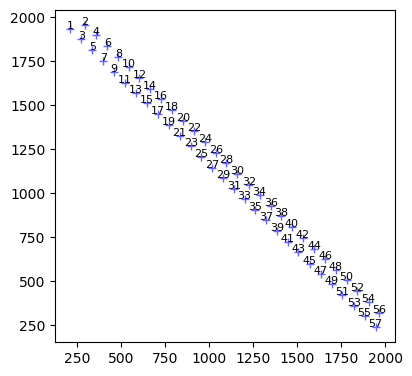

In [72]:
f

In [22]:
fw_w, rv_w = splitPhiRvFw(moves)
print(fw_w)

[   0   57   58 ... 2961 2962 2963]


In [19]:
phiRuns.keys()

dict_keys([0.015, 0.03, 0.045, 0.02, 0.025, 0.035, 0.05])

c:\users\cobra\documents\pfssoft\devel\ics_cobraCharmer\python\ics\cobraCharmer\pfiDesign.py:53: UserWarning: please use PFIDesign.loadModule() or PFIDesign.loadPFI()
  warnings.warn('please use PFIDesign.loadModule() or PFIDesign.loadPFI()')


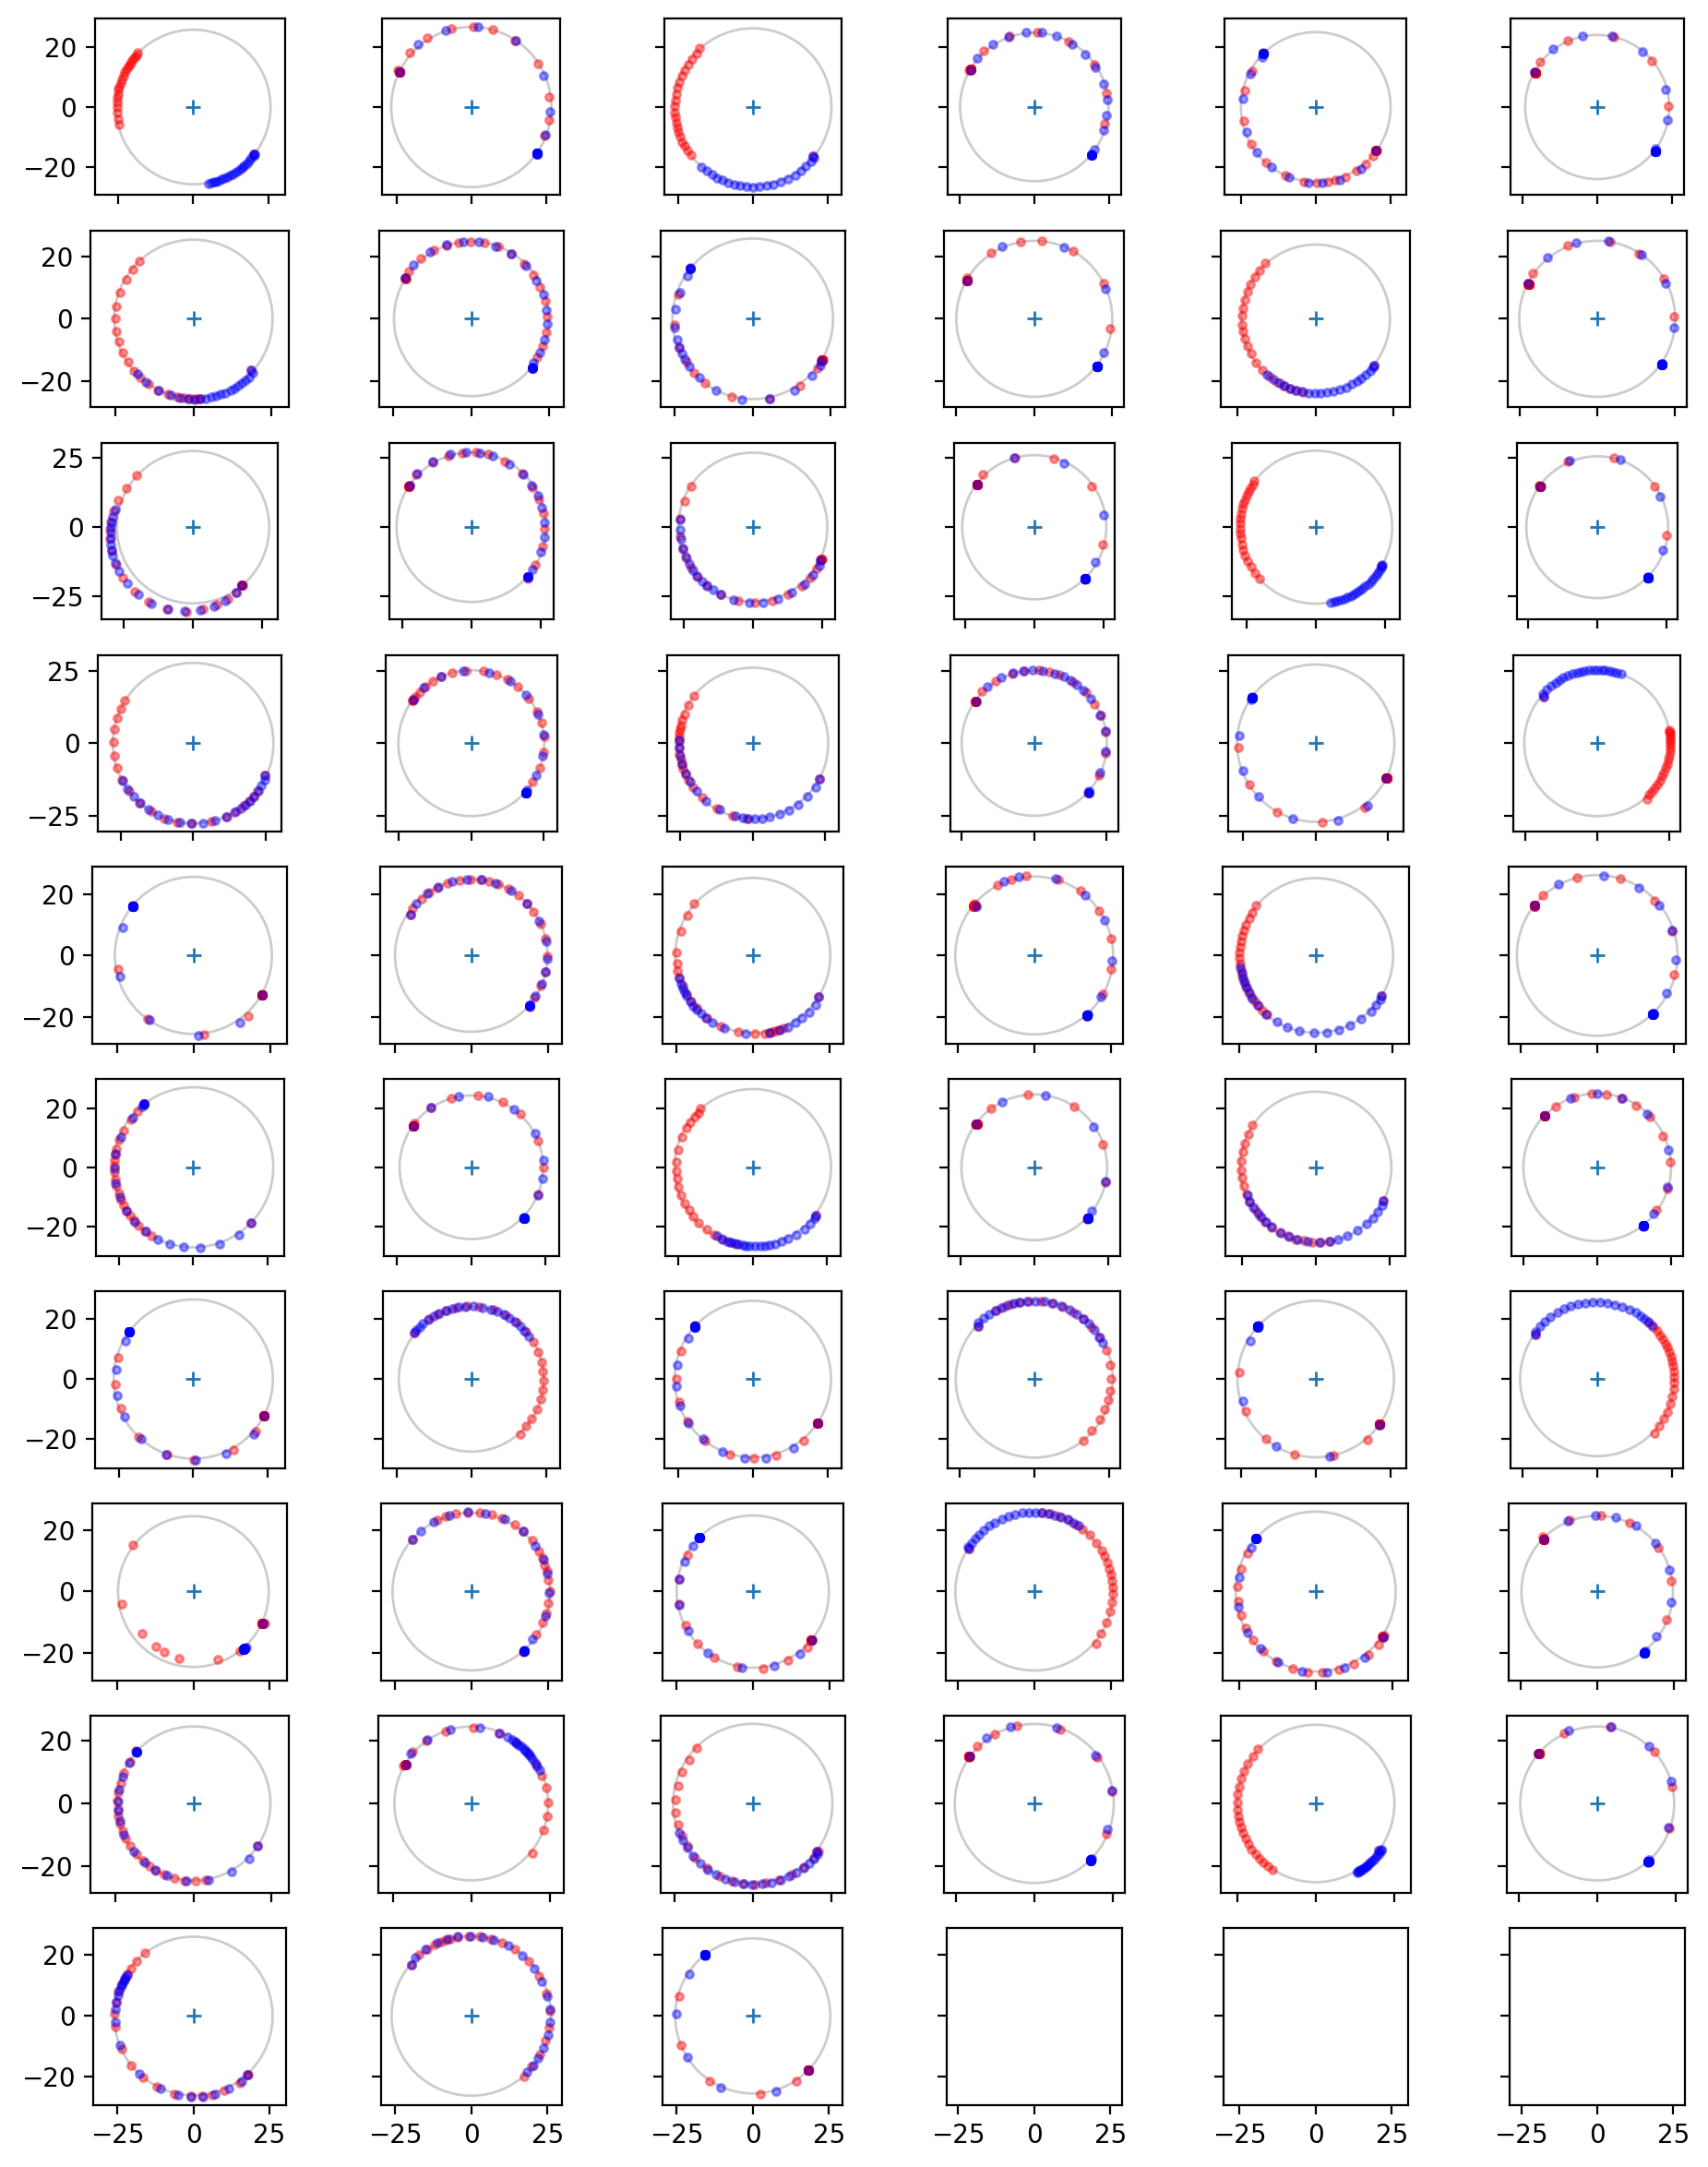

In [7]:
spots, moves= loadSpots(pathlib.Path(r'\data\MCS\20190820_050') / 'output')
map = pfiDesign.PFIDesign(pathlib.Path(r'\data\MCS\20190820_050') / 'output' / 'quickPhiScan.xml') # butler.mapPathForModule('SC42', 'phiOntime'))

ff,pl  = plotCobras(map, spots, moves, figname='f2')
ff.canvas.layout.height = '16in'
ff

In [156]:
ontime = 25
filename = f"phitest.xml"
run = phiRuns['opt']
#run = phiRuns[ontime/1000]

spots, moves = loadSpots(run['outputDir'])
mapname = run['outputDir'] / filename
map = pfiDesign.PFIDesign(mapname)
ff,pl  = plotCobras(map, spots, moves, figname='f2')
ff.canvas.layout.height = '16in'
ff

KeyError: 'opt'

> <ipython-input-156-09641089ec42>(3)<module>()
      1 ontime = 25
      2 filename = f"phitest.xml"
----> 3 run = phiRuns['opt']
      4 #run = phiRuns[ontime/1000]
      5 



ipdb>  c


In [51]:
f, pl = plotPhiArcs(spots, None, figname='fo')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
pfi.moveAllSteps(mt.allCobras, -10000, 0)

In [ ]:
mt.convertXML('spare1_convert.xml')

In [ ]:
mt.moveGoodCobrasOut()

In [ ]:
mt.makePhiMotorMap('20190516_003.xml', '/data/pfs/20190516/003', phiOnTime=0.03)

In [ ]:
mt.makeThetaMotorMap('20190516_003.xml', '/data/pfs/20190516/theta/003', thetaOnTime=0.03)